# Explore here

General Imports

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from imutils import paths
from matplotlib.image import imread

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.optimizers.legacy import Adam

from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image

In [2]:
'''zip_files = [
    {'zip_file': '~/.kaggle/dogs-vs-cats.zip'},
    {'zip_file': '~/Documents/Bootcamp/image_classifier_project/data/raw/test1.zip'},
    {'zip_file': '~/Documents/Bootcamp/image_classifier_project/data/raw/train.zip'}
]
extract_to_path = '~/Documents/Bootcamp/image_classifier_project/data/raw'

if not os.path.exists(extract_to_path):
    os.makedirs(extract_to_path)

for zip_info in zip_files:
    zip_file_path = zip_info['zip_file']
    
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
'''

"zip_files = [\n    {'zip_file': '~/.kaggle/dogs-vs-cats.zip'},\n    {'zip_file': '~/Documents/Bootcamp/image_classifier_project/data/raw/test1.zip'},\n    {'zip_file': '~/Documents/Bootcamp/image_classifier_project/data/raw/train.zip'}\n]\nextract_to_path = '~/Documents/Bootcamp/image_classifier_project/data/raw'\n\nif not os.path.exists(extract_to_path):\n    os.makedirs(extract_to_path)\n\nfor zip_info in zip_files:\n    zip_file_path = zip_info['zip_file']\n    \n    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:\n        zip_ref.extractall(extract_to_path)\n"


[Tensor Flow Tutorial](https://www.tensorflow.org/tutorials/load_data/images?_gl=1*71aj5d*_up*MQ..*_ga*MTMyNDIzMzgyNS4xNzI2OTA3NTU2*_ga_W0YLR4190T*MTcyNjkwNzU1NS4xLjAuMTcyNjkwNzU1NS4wLjAuMA..)

Load data using a Keras utility

Let's load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility

In [4]:
img_height = 200
img_width = 200
batch_size = 4

Load data using a Keras utility

In [16]:
main_directory = "/Documents/Bootcamp/image_classifier_project/data/raw/train"
training_dataset = image_dataset_from_directory(main_directory,
                        labels="inferred",
                        class_names=["cats","dogs"],
                        image_size=(img_height,img_width),
                        validation_split=0.1,
                        seed = 123,
                        subset="training",
                        batch_size=batch_size)

validation_dataset = image_dataset_from_directory(main_directory,
                        labels="inferred",
                        class_names=["cats","dogs"],
                        image_size=(img_height,img_width),
                        validation_split=0.1,
                        seed = 123,
                        subset="validation",
                        batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 22500 files for training.
Found 25000 files belonging to 2 classes.
Using 2500 files for validation.


In [17]:
class_names = training_dataset.class_names
print(class_names)

['cats', 'dogs']


Visualize the data

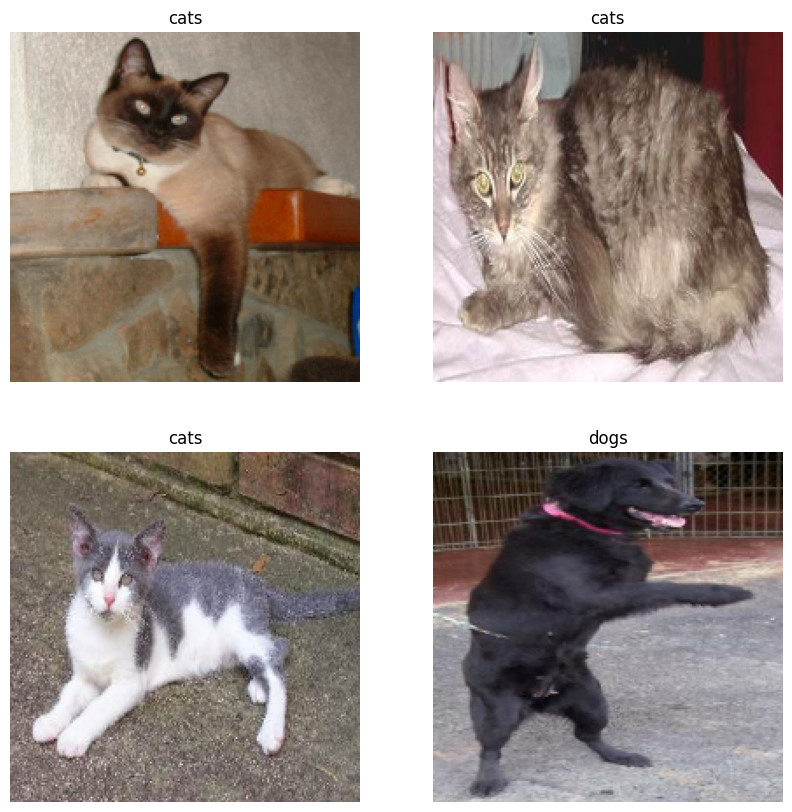

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in training_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 200, 200, 3)
(4,)


Cache for performance

In [9]:
AUTOTUNE=tf.data.AUTOTUNE

training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

`layers.Rescaling` was added for this purpose

Train a model

In [10]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

Choose the tf.keras.optimizers.Adam optimizer

In [11]:
model.compile(optimizer=Adam(learning_rate=0.000002),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 200, 200, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      3

In [13]:
#function that train the model
epochs=10
history = model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10


2024-09-22 14:26:43.283637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5625/5625 [==============================] - ETA: 0s - loss: 1.1338 - accuracy: 0.6372

2024-09-22 14:30:00.963235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5625/5625 [==============================] - 206s 36ms/step - loss: 1.1338 - accuracy: 0.6372 - val_loss: 0.8876 - val_accuracy: 0.6748
Epoch 2/10
5625/5625 [==============================] - 232s 41ms/step - loss: 0.7544 - accuracy: 0.7260 - val_loss: 0.8594 - val_accuracy: 0.7084
Epoch 3/10
5625/5625 [==============================] - 234s 42ms/step - loss: 0.5631 - accuracy: 0.7843 - val_loss: 0.8155 - val_accuracy: 0.7204
Epoch 4/10
5625/5625 [==============================] - 235s 42ms/step - loss: 0.3902 - accuracy: 0.8474 - val_loss: 0.8326 - val_accuracy: 0.7276
Epoch 5/10
5625/5625 [==============================] - 234s 41ms/step - loss: 0.2630 - accuracy: 0.8962 - val_loss: 0.8663 - val_accuracy: 0.7368
Epoch 6/10
5625/5625 [==============================] - 234s 42ms/step - loss: 0.1676 - accuracy: 0.9370 - val_loss: 0.8901 - val_accuracy: 0.7408
Epoch 7/10
5625/5625 [==============================] - 235s 42ms/step - loss: 0.1027 - accuracy: 0.9665 - val_loss: 0.9256 - val

Visualize training results

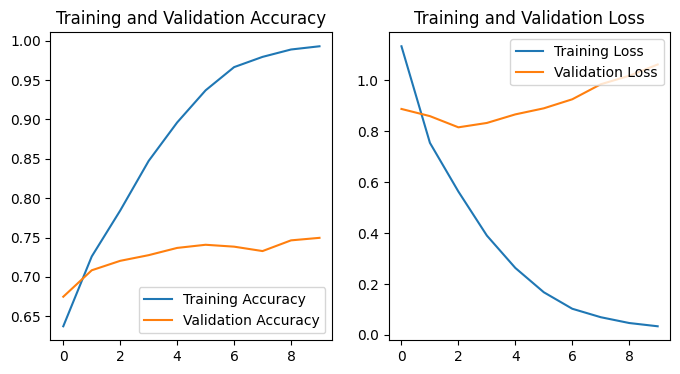

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict on new data
We are classifying an image that wasn't included in the training or validation sets.
5.jpg is a cat

In [15]:
img = tf.keras.utils.load_img(
    '/Documents/Bootcamp/image_classifier_project/data/raw/test1/5.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions[0])

score = tf.nn.softmax(predictions[0])
print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 319ms/step
[9.070238 7.207749]
tf.Tensor([0.8655868  0.13441318], shape=(2,), dtype=float32)
This image most likely belongs to cats with a 86.56 percent confidence.


2024-09-22 15:05:13.406031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
